# Modelo SIR COVID-19 México

### Corina Cerezo

In [1]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import PDEparams as pde
from datetime import datetime, timedelta, date

# Introducción

En este trabajo se aplica el método Monte Carlo para estimar los parámetros del modelo dinámico SIR con la base de datos de Covid-19 México (hasta la fecha 08 de dic de 2020). Posteriormente, una vez conocidos los parámetros, se grafica el modelo en comparación con los datos.

## Modelo SIR

El modelo SIR es un modelo matemático que nos permite predecir el comportamiento de una enfermedad infecciosa, a partir de ciertas condiciones iniciales. Este modelo clasifica a una población en tres grupos distintos:

* **S**: Susceptibles. Número de personas que son propensas a la enfermedad (que aún no se han enfermado).
* **I**: Infectados. Número de personas que tienen la enfermedad y que pueden infectar a la gente susceptible.
* **R**: Recuperado. Número de personas que no pueden contraer la enfermedad, porque se han recuperado completamente, o porque son inmunes o porque fallecieron.

Además este modelo usa principalmente dos parámetros:

* $\beta$: Tasa de transmisión. Describe qué tan rápido se transmite la infección de un individuo a otro (probabilidad de que una persona se enferme).
* $\gamma$: Tasa de recuperación. Describe qué tan rápido un individuo se recupera.

Ahora bien, la razón de cambio con respecto al tiempo $t$ de la cantidad de personas de los tres grupos ya mencionados está dada por:

$$\frac{\partial S}{\partial t} = -\beta \cdot S \cdot \frac{I}{N}$$
$$\frac{\partial I}{\partial t} = \beta \cdot S \cdot \frac{I}{N}-\gamma \cdot I$$
$$\frac{\partial R}{\partial t} = \gamma \cdot I$$

Estas tres forman un sistema de ecuaciones diferenciales que permiten modelar enfermedades infecciosas.


## Datos

Esta base de datos corresponde al informe de pacientes con Covid-19 hasta el día 08 de diciembre de 2020.

In [2]:
datos = pd.read_csv('201208COVID19MEXICO.csv', encoding = "ISO-8859-1")

In [3]:
datos.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,OTRO_CASO,TOMA_MUESTRA_LAB,RESULTADO_LAB,TOMA_MUESTRA_ANTIGENO,RESULTADO_ANTIGENO,CLASIFICACION_FINAL,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
0,2020-12-08,1468a5,1,4,5,1,15,5,18,1,...,1,1,1,2,97,3,99,MÃ©xico,97,97
1,2020-12-08,043f64,2,4,9,2,9,9,10,2,...,99,1,1,2,97,3,99,MÃ©xico,97,1
2,2020-12-08,0e07d8,1,4,15,2,15,15,104,2,...,99,1,1,2,97,3,99,MÃ©xico,97,2
3,2020-12-08,13757c,1,12,15,1,15,15,106,1,...,1,1,1,2,97,3,99,MÃ©xico,97,97
4,2020-12-08,002371,1,4,3,2,3,3,8,1,...,99,1,1,2,97,3,99,MÃ©xico,97,97


Se toman solo las variables de interes que son ID_REGISTRO, FECHA_SINTOMAS, FECHA_DEF y RESULTADO

In [4]:
datos = datos[['ID_REGISTRO', 'FECHA_SINTOMAS', 'FECHA_DEF', 'CLASIFICACION_FINAL']]
datos = datos.rename(columns={"CLASIFICACION_FINAL": "RESULTADO"}, errors="raise")
datos.head(15)

,ID_REGISTRO,FECHA_SINTOMAS,FECHA_DEF,RESULTADO
0,1468a5,2020-03-27,9999-99-99,3
1,043f64,2020-03-26,2020-03-30,3
2,0e07d8,2020-03-28,2020-04-02,3
3,13757c,2020-03-27,9999-99-99,3
4,002371,2020-03-27,9999-99-99,3
5,11fb00,2020-03-25,2020-04-05,3
6,092521,2020-03-28,9999-99-99,3
7,0955a5,2020-03-28,9999-99-99,3
8,1a1f12,2020-03-27,2020-03-31,3
9,12d93f,2020-03-20,9999-99-99,3


In [5]:
# Notemos a ver si existe gente rara
aux = datos[(datos['RESULTADO'] <= 3) & (datos['FECHA_DEF'] != "9999-99-99")]
aux['FECHA_SINTOMAS'] = pd.to_datetime(aux['FECHA_SINTOMAS'], format="%Y/%m/%d")
aux['FECHA_DEF'] = pd.to_datetime(aux['FECHA_DEF'], format="%Y/%m/%d")
raros = aux[aux['FECHA_SINTOMAS'] > aux['FECHA_DEF']]
raros.head(20)

,ID_REGISTRO,FECHA_SINTOMAS,FECHA_DEF,RESULTADO
1920860,2e7963,2020-08-27,2020-07-16,2


In [6]:
#esta persona se contagió de covid después de muerta jajajajaja
#como eso esta raro la quitamos
datos = datos.drop([1920860], axis = 0)

In [7]:
#Se cambia el tipo de dato de FECHA_SINTOMAS
datos['FECHA_SINTOMAS'] = pd.to_datetime(datos['FECHA_SINTOMAS'], format="%Y/%m/%d")
datos.head(5)

,ID_REGISTRO,FECHA_SINTOMAS,FECHA_DEF,RESULTADO
0,1468a5,2020-03-27,9999-99-99,3
1,043f64,2020-03-26,2020-03-30,3
2,0e07d8,2020-03-28,2020-04-02,3
3,13757c,2020-03-27,9999-99-99,3
4,002371,2020-03-27,9999-99-99,3


Se filtran los pacientes positivos a COVID-19 (con RESULTADO igual a 1, 2 o 3), podemos ver que para esa fecha son 1,193,254 contagiados.

In [8]:
positivos = datos[datos['RESULTADO'] <= 3]
print(positivos.info())
#positivos.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1193254 entries, 0 to 3053711
Data columns (total 4 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   ID_REGISTRO     1193254 non-null  object        
 1   FECHA_SINTOMAS  1193254 non-null  datetime64[ns]
 2   FECHA_DEF       1193254 non-null  object        
 3   RESULTADO       1193254 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 45.5+ MB
None


Para conocer los casos nuevos por día se suman los positivos por FECHA_SINTOMAS.

In [9]:
aux = positivos["FECHA_SINTOMAS"].value_counts()
infectados = pd.DataFrame(aux)
infectados.columns = ['infectados']
#infectados.tail(20)
print(infectados.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 296 entries, 2020-11-20 to 2020-02-23
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   infectados  296 non-null    int64
dtypes: int64(1)
memory usage: 4.6 KB
None


In [10]:
#Solo para verificar que los infectados suman los casos positivos
infectados['infectados'].sum()

1193254

Para contar los sobrevivientes por día se filtran todos los casos positivos (RESULTADO “1”, “2” o “3”) sin fecha de defunción (FECHA_DEF valor “99-99-9999”), pues serían los contagiados que no han muerto y se agrupan por la fecha que empezaron con los síntomas.

In [11]:
aux = datos[(datos['RESULTADO'] <= 3) & (datos['FECHA_DEF'] == '9999-99-99')]
aux = aux["FECHA_SINTOMAS"].value_counts()
sobrevivientes = pd.DataFrame(aux)
sobrevivientes.columns = ['sobre']
sobrevivientes.head(20)
print(sobrevivientes.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 295 entries, 2020-11-20 to 2020-02-23
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   sobre   295 non-null    int64
dtypes: int64(1)
memory usage: 4.6 KB
None


In [12]:
#Son 1,082,381 personas contagiadas hasta la fecha de
#la base de datos que siguen con vida
sobrevivientes['sobre'].sum()

1082381

Para contar los muertos por día se filtran todos los casos positivos (RESULTADO 1, 2 o 3) con fecha de defunción (FECHA_DEF distinto a “99-99-9999”) registrados en la base de datos y se agrupan por la fecha de defunción.

In [13]:
aux = positivos[(datos['RESULTADO'] <= 3) & (datos['FECHA_DEF'] != '9999-99-99')]
aux['FECHA_DEF'] = pd.to_datetime(aux['FECHA_DEF'], format = "%Y/%m/%d")
aux = aux["FECHA_DEF"].value_counts()
muertes = pd.DataFrame(aux)
muertes.columns = ['muertes']
#muertes.head(20)
print(muertes.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 267 entries, 2020-07-06 to 2020-12-08
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   muertes  267 non-null    int64
dtypes: int64(1)
memory usage: 4.2 KB
None


Podemos ver que solo hay 267 días, es decir, que ha habido días en los que la gente no muere.

In [14]:
#Acumulado de muertes hasta la fecha de la base de datos
#110,873 muertes
muertes['muertes'].sum()

110873

Vamos a construir un DataFrame. Para esto juntaremos en una misma base de datos, por día, los casos nuevos de infección, los casos sobrevivientes (estos son los contagiados recorridos 14 días, que implica que la gente ya sanó) y los casos de muertes.

In [15]:
#creamos una base de datos que tenga todos los días desde 23/feb/2020
#hasta 20/nov/2020
date_index = pd.date_range('2020/02/23', periods=272, freq='D')
aux0 = pd.DataFrame(index=date_index)
#Se unen los infectados
aux1 = pd.merge(left=aux0,right=infectados, how='outer', left_index=True, right_index=True)
aux1 = aux1.fillna(0)
#Se unen los muertos
aux2 = pd.merge(left=aux1,right=muertes, how='outer', left_index=True, right_index=True)
aux2 = aux2.fillna(0)
#Para los sobrevivientes quitamos las fechas de index y se hacen una columna más
aux3 = sobrevivientes.reset_index()
aux3.drop('index', axis = 1, inplace=False)
#Se suman 14 días a la fecha en que la persona se enfermo,
#dado que no murió entonces 14 días despúes se sanó
aux3['recorrido'] = aux3['index']+ timedelta(days=14)
#Se fija la fecha recorrida como index para poder unirla a la otra base de datos
aux3 = aux3.set_index(['recorrido'])
#Unimos la gente que sanó a la base de datos
ims = pd.merge(left=aux2,right=aux3, how='left', left_index=True, right_index=True)
ims = ims.fillna(0)
ims = ims.drop(['index'], axis='columns')
ims.tail(20)
#print(ims.info())
#len(ims)

,infectados,muertes,sobre
2020-11-19,6234,368.0,5454.0
2020-11-20,9882,435.0,5498.0
2020-11-21,6095,433.0,5059.0
2020-11-22,6262,473.0,4934.0
2020-11-23,7895,431.0,6674.0
2020-11-24,6631,431.0,7008.0
2020-11-25,7037,416.0,5495.0
2020-11-26,5919,453.0,5029.0
2020-11-27,6240,479.0,5001.0
2020-11-28,6185,422.0,4961.0


!Ahora sí! Se crea la base de datos para trabajar el modelo SIR. 

**NOTA:** La columna de Susceptibles no se puede estimar, pues aunque es la población que no se ha contagiado no basta con restar al total de la población los contagiados por COVID pues se tendrían que sumar los nacimientos y restar las defunciones, además de que el total de la población tampoco es un dato certero, por lo tanto, no se cuenta con el grupo de los Susceptibles.

In [16]:
#definimos la base de datos a trabajar
N=125000000
SIR_datos = {'t' : np.linspace(0, len(ims)-1, len(ims)),
#             'S' : N - ims.infectados - (ims.muertes + ims.sobre),
#             'S' : N - ims.infectados.cumsum(),
             'I' : ims.infectados,
             'R' : ims.muertes + ims.sobre}
SIR_datos = pd.DataFrame(SIR_datos)
#print(SIR_datos.info())
#SIR_datos.iloc[0,1] = N - SIR_datos.iloc[0,2] - SIR_datos.iloc[0,3]
SIR_datos.tail()

,t,I,R
2020-12-04,291.0,2020,9745.0
2020-12-05,292.0,1255,6184.0
2020-12-06,293.0,422,6263.0
2020-12-07,294.0,837,7692.0
2020-12-08,295.0,2,6438.0


Y las gráficas de infectados y recuperados son:

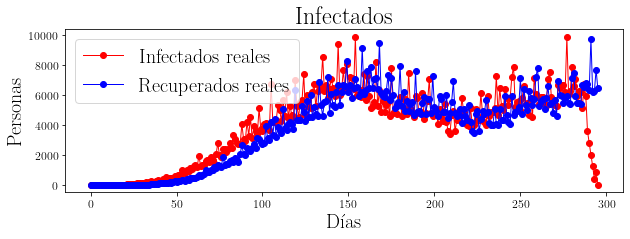

In [17]:
# Gráfica de los infectados
t = np.linspace(0, len(ims)-1, len(ims))
fig = plt.figure(figsize=(10,3))
plt.plot(t, SIR_datos.I, '-ok', color='r', label='Infectados reales', lw = 1)
plt.plot(t, SIR_datos.R, '-ok', color = 'b', label='Recuperados reales', lw = 1)
plt.xlabel('Días')
plt.ylabel('Personas')
plt.title('Infectados')
plt.legend()
plt.show()

## Monte carlo para los parámetros $\beta$ y $\gamma$

In [18]:
def deriv(z, t, b, g):
    S, I, R = z
    N = 125000000
    dSdt = -b * S * I / N
    dIdt = b * S * I / N - g * I
    dRdt = g * I
    return [dSdt, dIdt, dRdt]

In [19]:
# Valores iniciales
# Población total
N = 125000000
t = np.linspace(0, len(ims)-1, len(ims))
# Infectados al tiempo cero
def I0():
    return 1
# Recuperados al tiempo cero
def R0():
    return 0
# Susceptibles al tiempo 0
def S0():
    return N - 1

Para encontrar los mejores parámetros se corrieron muchos modelos "jugando" con la cota de los parámetros. Es importante mencionar que dado que $\gamma$ representa una tasa de recuperación, y puesto que por el contexto de la enfermedad no sucede que el día en el que te enfermas, mueres, entonces $\gamma$ solo puede tomar valores entre 0 y 1. Aunque es posible que otros valores mejoren el ajuste, por diseño del modelo ni tendría sentido.

### Monte Carlo con sólo el grupo de Infectados observados

In [20]:
#Se va a trabajar solo con la columna del tiempo y de Infectados
SIR_datos[['t','I']]

,t,I
2020-01-13,0.0,1
2020-01-27,1.0,1
2020-01-29,2.0,1
2020-02-06,3.0,1
2020-02-19,4.0,2
...,...,...
2020-12-04,291.0,2020
2020-12-05,292.0,1255
2020-12-06,293.0,422
2020-12-07,294.0,837


In [21]:
%%time
evaluaciones = []
for b in range(1,5):
    for s in range(2,30):
        g = 1/s
        my_model = pde.PDEmodel(SIR_datos[['t','I']], deriv, [S0, I0, R0], bounds=[(0,b), (g,1)], 
                        param_names=[r'$beta$', r'$gamma$'], nvars=3, ndims=0, nreplicates=1, obsidx=[1], outfunc=None)
        my_model.fit()
        evaluaciones.append([my_model.best_params.iloc[0,0],my_model.best_params.iloc[0,1],my_model.best_error, b, g])
#print(evaluaciones)

   $beta$   $gamma$
0     1.0  0.968716
     $beta$   $gamma$
0  0.527798  0.496727
     $beta$   $gamma$
0  0.398685  0.367648
   $beta$   $gamma$
0     1.0  0.968716
   $beta$   $gamma$
0     1.0  0.968716
   $beta$   $gamma$
0     1.0  0.968716
   $beta$   $gamma$
0     1.0  0.968716
   $beta$   $gamma$
0     1.0  0.968716
     $beta$   $gamma$
0  0.357369  0.326341
   $beta$   $gamma$
0     1.0  0.968716
   $beta$   $gamma$
0     1.0  0.968716
   $beta$   $gamma$
0     1.0  0.968716
   $beta$   $gamma$
0     1.0  0.968716
   $beta$   $gamma$
0     1.0  0.968716
   $beta$   $gamma$
0     1.0  0.968716
   $beta$   $gamma$
0     1.0  0.968716
   $beta$   $gamma$
0     1.0  0.968716
   $beta$   $gamma$
0     1.0  0.968716
   $beta$   $gamma$
0     1.0  0.968716
   $beta$   $gamma$
0     1.0  0.968716
   $beta$   $gamma$
0     1.0  0.968716
   $beta$   $gamma$
0     1.0  0.968716
   $beta$   $gamma$
0     1.0  0.968716
   $beta$   $gamma$
0     1.0  0.968716
   $beta$   $gamma$
0     1.

In [22]:
#Esta función sirve para ordenar
def Sort(sub_li): 
    sub_li.sort(key = lambda x: x[2]) 
    return sub_li 

In [23]:
#Ordenamos las evaluaciones
eval_ord = Sort(evaluaciones)
print("El parámetro Beta está entre 0 y",eval_ord[0][3],
      " y el parámetro Gamma está entre", eval_ord[0][4],
      "y 1.")

El parámetro Beta está entre 0 y 3  y el parámetro Gamma está entre 0.125 y 1.


In [24]:
%%time
my_model = pde.PDEmodel(SIR_datos[['t','I']], deriv, [S0, I0, R0], bounds=[(0,eval_ord[0][3]), (eval_ord[0][4],1)], 
                        param_names=[r'$beta$', r'$gamma$'], nvars=3, ndims=0, nreplicates=1, obsidx=(1), outfunc=None)
my_model.fit()

     $beta$  $gamma$
0  1.031304      1.0
Wall time: 1.31 s


In [25]:
print(my_model.best_error)

16455230.413653642


In [26]:
my_model.best_params

,$beta$,$gamma$
0,1.031304,1.0


#### Likelihood Profile

In [27]:
%%time
my_model.likelihood_profiles()



Wall time: 4min 17s


In [28]:
my_model.result_profiles

,parameter,value,error
0,$beta$,0.000000,2.223475e+07
1,$beta$,0.030303,2.223475e+07
2,$beta$,0.060606,2.223474e+07
3,$beta$,0.090909,2.223467e+07
4,$beta$,0.121212,2.223392e+07
...,...,...,...
195,$gamma$,0.964646,1.646671e+07
196,$gamma$,0.973485,1.646388e+07
197,$gamma$,0.982323,1.646103e+07
198,$gamma$,0.991162,1.645814e+07


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


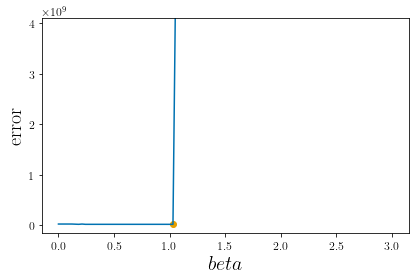

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


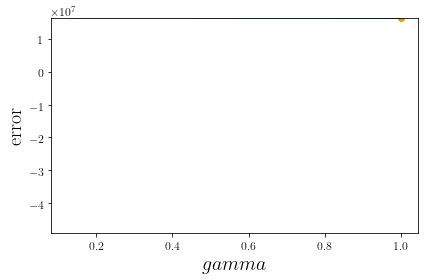

In [29]:
my_model.plot_profiles()

#### Gráficas del modelo SIR con sólo el grupo de Infectados observado

In [30]:
#Extraemos los valores del mejor modelo
b = my_model.best_params.iloc[0,0]
g = my_model.best_params.iloc[0,1]
#Recordemos los valores iniciales
N = 125000000
I0 = 1
R0 = 0
S0 = N - I0 - R0
z0 = S0, I0, R0
t = np.linspace(0, len(ims)-1, len(ims))

In [31]:
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, z0, t, args=(b, g))
S, I, R = ret.T

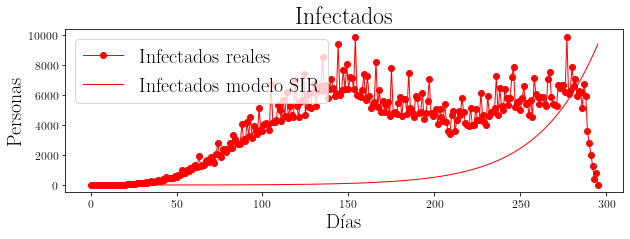

In [32]:
# Gráfica de los infectados
fig = plt.figure(figsize=(10,3))
plt.plot(t, SIR_datos.I, '-ok', color='r', label='Infectados reales', lw = 1)
plt.plot(t, I, color = 'r', label='Infectados modelo SIR', lw = 1)
plt.xlabel('Días')
plt.ylabel('Personas')
plt.title('Infectados')
plt.legend()
plt.show()

### Monte Carlo con los grupos de Infectados y Recuperados observados

In [33]:
# Valores iniciales
# Población total
N = 125000000
t = np.linspace(0, len(ims)-1, len(ims))
# Infectados al tiempo cero
def I0():
    return 1
# Recuperados al tiempo cero
def R0():
    return 0
# Susceptibles al tiempo 0
def S0():
    return N - 1

In [34]:
%%time
evaluaciones = []
for b in range(1,5):
    for s in range(2,30):
        g = 1/s
        my_model = pde.PDEmodel(SIR_datos, deriv, [S0, I0, R0], bounds=[(0,b), (g,1)], 
                        param_names=[r'$beta$', r'$gamma$'], nvars=3, ndims=0, nreplicates=1, obsidx=[1,2], outfunc=None)
        my_model.fit()
        evaluaciones.append([my_model.best_params.iloc[0,0],my_model.best_params.iloc[0,1],my_model.best_error, b, g])
#print(evaluaciones)

   $beta$   $gamma$
0     1.0  0.982269
   $beta$   $gamma$
0     1.0  0.982269
   $beta$   $gamma$
0     1.0  0.982269
   $beta$   $gamma$
0     1.0  0.982269
     $beta$   $gamma$
0  0.997495  0.979753
   $beta$   $gamma$
0     1.0  0.982269
   $beta$   $gamma$
0     1.0  0.982269
   $beta$   $gamma$
0     1.0  0.982269
   $beta$   $gamma$
0     1.0  0.982269
   $beta$   $gamma$
0     1.0  0.982269
     $beta$   $gamma$
0  0.982551  0.964739
   $beta$   $gamma$
0     1.0  0.982269
   $beta$   $gamma$
0     1.0  0.982269
     $beta$   $gamma$
0  0.961488  0.943603
   $beta$   $gamma$
0     1.0  0.982269
   $beta$   $gamma$
0     1.0  0.982269
   $beta$   $gamma$
0     1.0  0.982269
   $beta$   $gamma$
0     1.0  0.982269
   $beta$   $gamma$
0     1.0  0.982269
    $beta$   $gamma$
0  0.07798  0.047619
     $beta$   $gamma$
0  0.075942  0.045455
   $beta$   $gamma$
0     1.0  0.982269
   $beta$   $gamma$
0     1.0  0.982269
     $beta$   $gamma$
0  0.072322  0.041611
   $beta$   $gamma

In [35]:
#Esta función sirve para ordenar
def Sort(sub_li): 
    sub_li.sort(key = lambda x: x[2]) 
    return sub_li 

In [36]:
#Ordenamos las evaluaciones
eval_ord = Sort(evaluaciones)
print("El parámetro Beta está entre 0 y",eval_ord[0][3],
      " y el parámetro Gamma está entre", eval_ord[0][4],
      "y 1.")

El parámetro Beta está entre 0 y 4  y el parámetro Gamma está entre 0.034482758620689655 y 1.


In [37]:
%%time
my_model = pde.PDEmodel(SIR_datos[['t','I']], deriv, [S0, I0, R0], bounds=[(0,eval_ord[0][3]), (eval_ord[0][4],1)], 
                        param_names=[r'$beta$', r'$gamma$'], nvars=3, ndims=0, nreplicates=1, obsidx=(1), outfunc=None)
my_model.fit()

     $beta$  $gamma$
0  1.031304      1.0
Wall time: 2.27 s


In [38]:
print(my_model.best_error)

16455230.413686845


In [39]:
my_model.best_params

,$beta$,$gamma$
0,1.031304,1.0


#### Likelihood Profile

In [40]:
%%time
my_model.likelihood_profiles()



Wall time: 4min 31s


In [41]:
my_model.result_profiles

,parameter,value,error
0,$beta$,0.000000,2.223469e+07
1,$beta$,0.040404,2.223415e+07
2,$beta$,0.080808,1.661691e+07
3,$beta$,0.121212,1.661569e+07
4,$beta$,0.161616,2.218714e+07
...,...,...,...
195,$gamma$,0.960989,1.646789e+07
196,$gamma$,0.970742,1.646488e+07
197,$gamma$,0.980495,1.646163e+07
198,$gamma$,0.990247,1.645851e+07


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


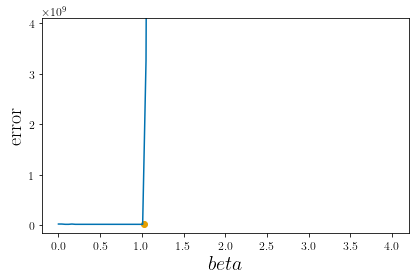

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


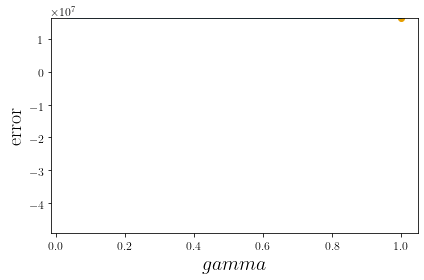

In [42]:
my_model.plot_profiles()

#### Gráficas del modelo SIR con los grupos de Infectados y Recuperados observados

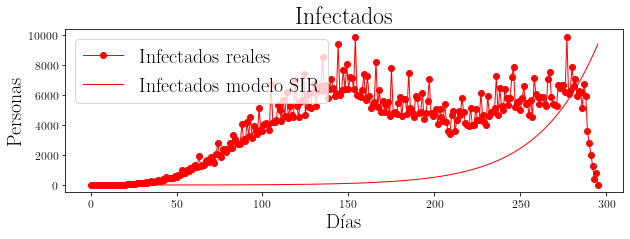

In [43]:
# Gráfica de los infectados
fig = plt.figure(figsize=(10,3))
plt.plot(t, SIR_datos.I, '-ok', color='r', label='Infectados reales', lw = 1)
plt.plot(t, I, color = 'r', label='Infectados modelo SIR', lw = 1)
plt.xlabel('Días')
plt.ylabel('Personas')
plt.title('Infectados')
plt.legend()
plt.show()

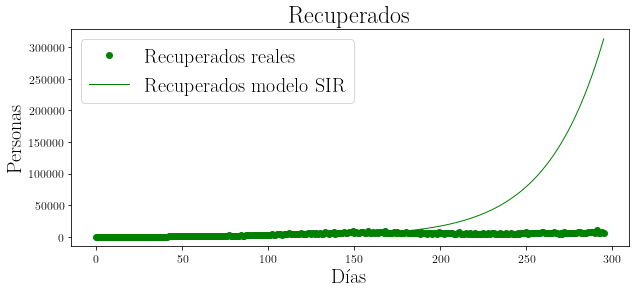

In [44]:
# Gráfica de los Recuperados
fig = plt.figure(figsize=(10,4))
plt.plot(t, SIR_datos.R, 'o', color='g', label='Recuperados reales', lw = 1)
plt.plot(t, R, color = 'g', label='Recuperados modelo SIR', lw = 1)
plt.xlabel('Días')
plt.ylabel('Personas')
plt.title('Recuperados')
plt.legend()
plt.show()

## Referencias:

https://datos.covid-19.conacyt.mx/#DownZCSV

https://www.inegi.org.mx/contenidos/saladeprensa/aproposito/2020/Poblacion2020_Nal.pdf

https://python.quantecon.org/sir_model.html

https://www.mscbs.gob.es/biblioPublic/publicaciones/recursos_propios/resp/revista_cdrom/VOL94/C_ESPECIALES/RS94C_202009109.pdf

https://www.medigraphic.com/pdfs/forense/mmf-2020/mmf203c.pdf